<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Using the new big bulk data to train

Using Min MSE

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. New loss function.
  - Using modulo and sigmoid
7. Modified R2 score
8. Gene normalization
9. Using original batch data.

TODO:
  - Reduce the bulk into smaller.

## Import libraries

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets
# path = Path('data/circadian')
path = Path('data')

In [6]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [7]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [8]:
# loss_func = F.mse_loss
def bin_mse2(inp, targ):
    # import pdb; pdb.set_trace()
    # t = torch.stack([(inp-targ)**2, (inp-targ-24)**2, (inp-targ+24)**2])
    # return torch.mean(torch.min(t, dim=0).values)
    # return torch.mean(torch.min((inp-targ)**2, (inp-targ-24)**2)) # torch.Size([128, 1])
    return torch.mean(torch.min((inp-targ)**2, torch.min((inp-targ-24)**2, (inp-targ+24)**2))) # torch.Size([128, 1])
loss_func = bin_mse2

In [9]:
class TimeLayer(nn.Module):
    def __init__(self, range = 26):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [10]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
# metric = R2Score()

In [11]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [12]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

In [13]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)

In [14]:
raw_data.head()

,gene,AAACAGCCAACCCTAA-6,AAACCAACAGTAAAGC-6,AAACCGAAGGTCCTAG-6,AAAGCACCATTGTCCT-6,AAAGGACGTGAGGTGA-6,AAAGGAGCAAAGCGCA-6,AACAAAGGTAAAGCGG-6,AACAGATAGACTATTG-6,AACATAGCATGAGCAG-6,...,TTAGGATGTTTATCTG-7,TTATCCGTCACCTGCT-7,TTATTGCTCAAGTGTC-7,TTCCTTGAGTAAAGGT-7,TTCGTTAGTAACGAGG-7,TTGCCCGTCGCACAAT-7,TTGCGTCTCTTAGTCT-7,TTGGGTTAGCCACAAT-7,TTTAGCTTCAGGAAGC-7,TTTGGTAAGGAAGTAT-7
0,Meg3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Slc1a2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cyp2c40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cyp2c69,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
meta_data.head()

,cell_name,ZT
0,AAACAGCCAACCCTAA-6,ZT18
1,AAACCAACAGTAAAGC-6,ZT18
2,AAACCGAAGGTCCTAG-6,ZT18
3,AAAGCACCATTGTCCT-6,ZT18
4,AAAGGACGTGAGGTGA-6,ZT18


In [16]:
data = raw_data.set_index('gene').T
cell_sums = data.sum(axis=1)
cell_divided = data.div(cell_sums, axis=0)
nrm = (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)
data = nrm
df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
data2 = data.join(df_mis)
df = data2.join(meta_data.set_index('cell_name'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

In [17]:
batch_ct = pd.read_csv(path/'sc_RNA_ct.csv', low_memory=False)
batch_zt = pd.read_csv(path/'sc_RNA_ZT.csv', low_memory=False)
batch_ct.head()

,Unnamed: 0,AAACAGCCAGCAATAA.8,AAACGCGCAGTATGTT.8,AAAGCGGGTGCATCGG.8,AAAGGACGTAAGGTTT.8,AAAGGAGCAACCGCCA.8,AACCCGCAGGCCAATT.8,AACCCGCAGTCATTAG.8,AACTAGCTCGTACCGA.8,AACTAGCTCTGTAAGC.8,...,CTCCCTGAGAGCCGCT.2,CTTGCATGTAAGGTCC.2,GCTAAGTTCTAAGTGC.2,GCTCACAAGCTGGACC.2,GCTGCACAGTAGCGGG.2,GTCCAAGTCTACTAAG.2,TACCGTTGTTACGCAA.2,TCCATCATCAGGTTTA.2,TCGTTAGCAGTAGGAT.2,TGAACAGAGTGATTCA.2
0,Xkr4,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1,Rp1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Sox17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mrpl15,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,Lypla1,1,4,0,0,2,6,2,5,0,...,0,0,0,2,0,0,1,1,0,0


In [18]:
batch_ct.iloc[:,0]

0           Xkr4
1            Rp1
2          Sox17
3         Mrpl15
4         Lypla1
          ...   
16363    mt-Nd4l
16364     mt-Nd4
16365     mt-Nd5
16366     mt-Nd6
16367    mt-Cytb
Name: Unnamed: 0, Length: 16368, dtype: object

In [19]:
batch_zt.head()

,Unnamed: 0,ZT
0,AAACAGCCAGCAATAA-8,ZT18
1,AAACGCGCAGTATGTT-8,ZT18
2,AAAGCGGGTGCATCGG-8,ZT18
3,AAAGGACGTAAGGTTT-8,ZT18
4,AAAGGAGCAACCGCCA-8,ZT18


In [20]:
raw_data = batch_ct
raw_data.columns = raw_data.columns.str.replace('.', '-')
meta_data = batch_zt

data = raw_data.set_index('Unnamed: 0').T
cell_sums = data.sum(axis=1)
cell_divided = data.div(cell_sums, axis=0)
nrm = (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)
data = nrm
# df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
# data2 = data.join(df_mis)
df = data.join(meta_data.set_index('Unnamed: 0'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

In [21]:
df.head()

,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,4732440D04Rik,...,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,ZT,code
AAACAGCCAGCAATAA-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.363687,-0.633744,-0.048407,-0.626202,-0.174223,-0.312544,...,-0.368729,-0.094769,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.000030,ZT18,18.0
AAACGCGCAGTATGTT-8,-0.049673,-0.04268,-0.124963,-0.489307,2.078659,-0.633744,-0.048407,-0.626202,1.304845,-0.312544,...,-0.190708,-0.086019,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213,ZT18,18.0
AAAGCGGGTGCATCGG-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,0.477558,-0.168903,-0.312544,...,-0.264324,-0.092338,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213,ZT18,18.0
AAAGGACGTAAGGTTT-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,0.512518,-0.312544,...,-0.286073,0.218951,-0.293294,-0.212751,-0.432418,1.039197,-0.118702,-0.041078,ZT18,18.0
AAAGGAGCAACCGCCA-8,-0.049673,-0.04268,-0.124963,-0.489307,1.023501,-0.633744,-0.048407,-0.626202,0.480769,-0.312544,...,-0.107936,-0.140863,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.048753,ZT18,18.0


### Bulk + scRNA-seq

In [22]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [23]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [24]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [25]:
bulk_data = raw_bulk_data.set_index('ID').T
bulk_data = (bulk_data - bulk_data.mean(axis=0)) / bulk_data.std(axis=0)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [26]:
bulk_data.head()

ID,2810459M11Rik,Abcb11,Acot7,Ahctf1,Ap2a2,Asb13,Asl,Chka,Clic3,Clpx,...,Ap1s3,Vamp4,Pigm,Pard6g,Gas2,Pot1b,Zfp759,Neo1,Sco1,code
ZT2_1,1.105385,1.734929,-1.000468,-0.675204,0.840018,0.483757,-1.549016,0.124098,-0.232362,0.848045,...,2.752890,-0.473227,1.929628,0.128575,-0.790649,-0.444183,0.143286,-0.561441,-0.562906,2
ZT6_1,0.140685,0.362813,0.216831,-1.176028,-0.819429,-0.259607,-0.637751,-1.136919,-0.522711,-1.026734,...,-0.789960,0.250906,-0.690604,0.128575,0.738327,-1.036427,-1.197874,1.199442,0.094325,6
ZT10_1,-0.816706,-1.059483,0.376602,-0.640493,-1.968277,-1.844144,0.759326,-1.019758,-0.540232,-1.165550,...,0.215444,0.250906,-0.243742,-1.651693,-0.302307,-0.049354,1.828333,-1.939524,-1.767828,10
ZT14_1,-0.746059,-0.951535,1.700414,0.762807,-0.123532,-0.425885,0.793645,-0.165720,-0.294937,-0.431148,...,0.550578,1.622947,0.487485,0.959366,0.023254,-0.049354,-0.647654,1.429123,1.372273,14
ZT18_1,0.250310,-0.396195,0.361386,1.328094,0.432362,0.625583,0.991523,0.580407,0.012932,1.159798,...,-0.406949,-1.197360,0.934346,-0.108794,1.197601,0.740305,0.074509,-0.178640,0.422940,18


In [27]:
gro = raw_gro.set_index('ID').T
nascent = raw_nascent.set_index('ID').T
gro = (gro - gro.mean(axis=0)) / gro.std(axis=0)
nascent = (nascent - nascent.mean(axis=0)) / nascent.std(axis=0)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

Since new batch data is bigger, we gotta change shapes.

In [28]:
column_intersections = df.columns.intersection(bulk_data.columns)
column_intersections

Index(['Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1', 'Pcmtd1',
       'Rrs1', 'Adhfe1', 'Mybl1',
       ...
       'Afap1l2', 'Trub1', 'Hspa12a', 'Slc18a2', 'Pdzd8', 'Rab11fip2', 'Sfxn4',
       'Prdx3', 'Csf2ra', 'code'],
      dtype='object', length=9335)

In [29]:
df = df.loc[:,column_intersections]
df

,Sox17,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Adhfe1,Mybl1,...,Afap1l2,Trub1,Hspa12a,Slc18a2,Pdzd8,Rab11fip2,Sfxn4,Prdx3,Csf2ra,code
AAACAGCCAGCAATAA-8,-0.124963,-0.489307,-0.363687,-0.633744,-0.626202,-0.174223,1.181735,-0.307267,-0.287939,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,18.0
AAACGCGCAGTATGTT-8,-0.124963,-0.489307,2.078659,-0.633744,-0.626202,1.304845,0.364943,2.984634,0.723687,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,18.0
AAAGCGGGTGCATCGG-8,-0.124963,-0.489307,-0.912213,-0.633744,0.477558,-0.168903,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,18.0
AAAGGACGTAAGGTTT-8,-0.124963,-0.489307,-0.912213,-0.633744,-0.626202,0.512518,0.349555,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,0.930811,-0.404423,-0.091748,-0.334582,-0.080832,18.0
AAAGGAGCAACCGCCA-8,-0.124963,-0.489307,1.023501,-0.633744,-0.626202,0.480769,1.445405,-0.307267,0.160050,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCCAAGTCTACTAAG-2,-0.124963,-0.489307,-0.912213,-0.633744,-0.626202,-1.031017,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,6.0
TACCGTTGTTACGCAA-2,-0.124963,-0.489307,0.426962,-0.633744,-0.626202,-1.031017,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,6.0
TCCATCATCAGGTTTA-2,-0.124963,-0.489307,0.745681,1.589905,-0.626202,-1.031017,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,6.0
TCGTTAGCAGTAGGAT-2,-0.124963,-0.489307,-0.912213,-0.633744,-0.626202,-1.031017,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,6.0


In [30]:
# bulk_genes_set = set(raw_bulk_data['ID'])
# sc_genes = raw_data['gene']

In [31]:
# genes = [gene for gene in sc_genes if gene in bulk_genes_set]

In [32]:
# mis_genes = [gene for gene in sc_genes if gene not in bulk_genes_set]

In [33]:
def make_df(dataset):
    return dataset.loc[:,column_intersections]

In [34]:
nascent_df = make_df(nascent)
gro_df = make_df(gro)
rna_df = make_df(bulk_data)

## Using Pytorch

In [35]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-1]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_6375/705046130.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.float)


In [36]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [37]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [38]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([20855, 1]), torch.Size([5213, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [39]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 9334]), torch.Size([128, 1]))

In [40]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [41]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl}

/tmp/ipykernel_6375/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_6375/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_6375/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)


Changing the metric to R2Score.

In [42]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [43]:
len(indep_cols)

9334

In [44]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [45]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [46]:
get_model()(xb).shape

torch.Size([128, 1])

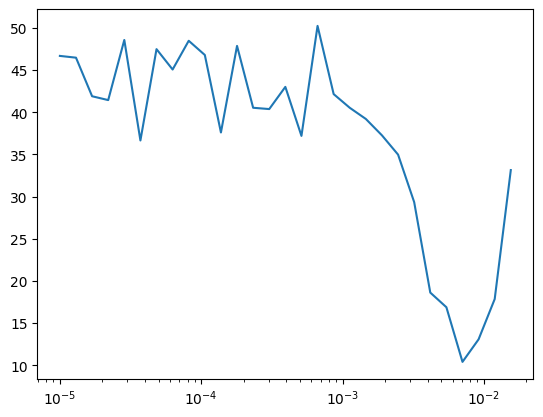

In [47]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.247,33.475,0,True,00:02
0.575,18.660,0,False,00:00
0.749,11.139,1,True,00:02
0.782,9.596,1,False,00:00
0.870,5.782,2,True,00:02
0.816,8.102,2,False,00:00
0.915,3.774,3,True,00:02
0.828,7.543,3,False,00:00
0.940,2.666,4,True,00:02
0.835,7.226,4,False,00:00


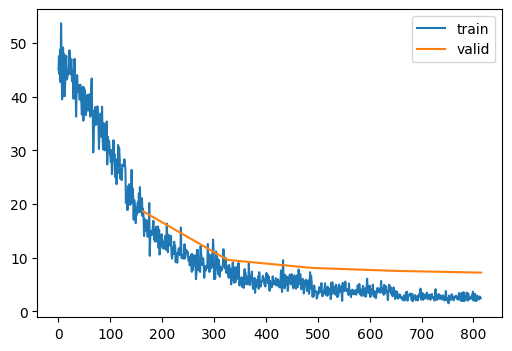

In [48]:
lr, epochs = 1e-4, 5
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [49]:
from functools import partial

In [50]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [51]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        print('result: ', metric.compute())

In [52]:
nlearn = 2

Training models


TimeR2Score,loss,epoch,train,time
0.757,10.777,0,True,00:02
0.840,7.014,0,False,00:00
0.940,2.686,1,True,00:03
0.861,6.112,1,False,00:00


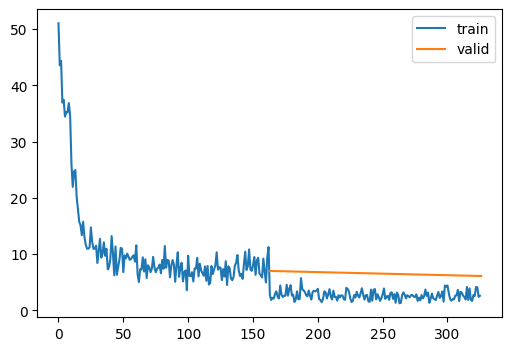

TimeR2Score,loss,epoch,train,time
0.754,10.920,0,True,00:02
0.848,6.692,0,False,00:00
0.947,2.333,1,True,00:03
0.847,6.721,1,False,00:00


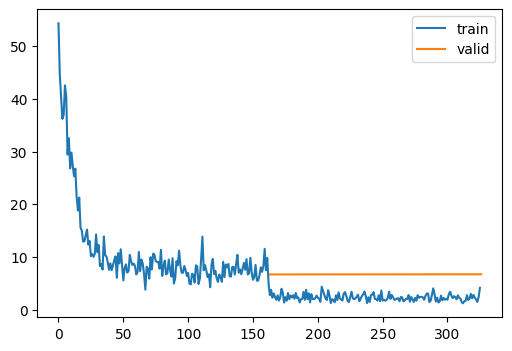

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.130,40.590,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.395,28.253,0,False,00:00


Inference on nascent
		preds, targs
tensor([[10.4465,  0.0000],
        [ 2.6605,  4.0000],
        [ 9.9241,  8.0000],
        [ 5.7917, 12.0000],
        [ 8.8025, 16.0000],
        [23.9847, 20.0000],
        [ 2.9734,  0.0000],
        [-0.4896,  4.0000],
        [18.7877,  8.0000],
        [11.0961, 12.0000],
        [15.6062, 16.0000],
        [24.7312, 20.0000]])
result:  tensor(0.3043)


TimeR2Score,loss,epoch,train,time
0.623,17.798,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.573,20.172,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 3.4255,  1.0000],
        [ 4.4920,  4.0000],
        [ 3.0871,  7.0000],
        [ 8.4892, 10.0000],
        [15.5523, 13.0000],
        [ 1.4132, 16.0000],
        [24.1615, 19.0000],
        [24.1724, 22.0000]])
result:  tensor(0.6026)


TimeR2Score,loss,epoch,train,time
0.578,19.690,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.566,20.234,0,False,00:00


Inference on rna
		preds, targs
tensor([[10.9353,  2.0000],
        [ 4.4367,  6.0000],
        [ 7.9901, 10.0000],
        [13.5573, 14.0000],
        [24.1132, 18.0000],
        [24.2297, 22.0000],
        [ 2.9073,  2.0000],
        [ 9.7402,  6.0000],
        [11.1450, 10.0000],
        [10.1363, 14.0000],
        [14.4804, 18.0000],
        [ 6.1101, 22.0000]])
result:  tensor(0.5749)


In [53]:
ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [54]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [55]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

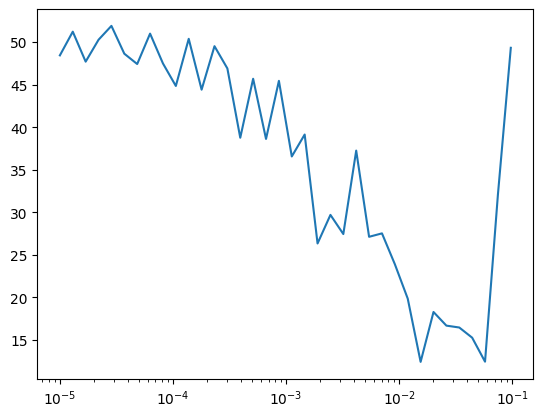

In [56]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.739,11.584,0,True,00:03
0.796,8.967,0,False,00:00
0.819,8.035,1,True,00:03
0.855,6.354,1,False,00:00
0.879,5.383,2,True,00:03
0.873,5.583,2,False,00:00
0.917,3.696,3,True,00:03
0.882,5.173,3,False,00:00


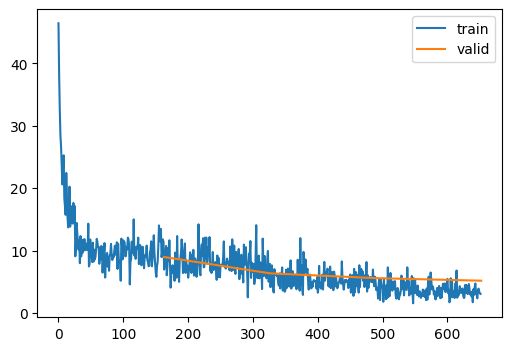

TimeR2Score,loss,epoch,train,time
0.737,11.673,0,True,00:03
0.738,11.512,0,False,00:00
0.789,9.367,1,True,00:03
0.837,7.151,1,False,00:00
0.858,6.320,2,True,00:02
0.856,6.320,2,False,00:00
0.915,3.774,3,True,00:02
0.862,6.074,3,False,00:00


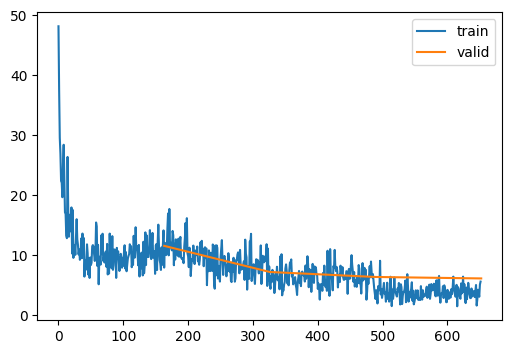

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.913,4.075,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.677,15.091,0,False,00:00


Inference on nascent
		preds, targs
tensor([[15.3771,  0.0000],
        [ 4.6185,  4.0000],
        [ 9.8239,  8.0000],
        [ 8.1194, 12.0000],
        [15.7879, 16.0000],
        [21.2901, 20.0000],
        [ 1.6406,  0.0000],
        [ 3.3748,  4.0000],
        [11.1760,  8.0000],
        [ 9.9555, 12.0000],
        [14.7514, 16.0000],
        [21.0857, 20.0000]])
result:  tensor(0.7948)


TimeR2Score,loss,epoch,train,time
0.634,17.287,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.467,25.199,0,False,00:00


Inference on gro
		preds, targs
tensor([[14.4061,  1.0000],
        [16.6965,  4.0000],
        [ 6.9251,  7.0000],
        [ 9.5023, 10.0000],
        [12.7009, 13.0000],
        [ 6.2272, 16.0000],
        [20.2806, 19.0000],
        [19.6489, 22.0000]])
result:  tensor(0.0925)


TimeR2Score,loss,epoch,train,time
0.622,17.655,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.535,21.715,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 7.0868,  2.0000],
        [ 6.3558,  6.0000],
        [ 9.4461, 10.0000],
        [14.2515, 14.0000],
        [24.1080, 18.0000],
        [20.6082, 22.0000],
        [ 7.6173,  2.0000],
        [ 9.3110,  6.0000],
        [10.7932, 10.0000],
        [10.4444, 14.0000],
        [13.8815, 18.0000],
        [ 9.2756, 22.0000]])
result:  tensor(0.5259)


In [57]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.742,11.478,0,True,00:02
0.804,8.601,0,False,00:00
0.820,8.009,1,True,00:02
0.843,6.876,1,False,00:00
0.881,5.280,2,True,00:02
0.868,5.807,2,False,00:00
0.925,3.337,3,True,00:02
0.870,5.696,3,False,00:00


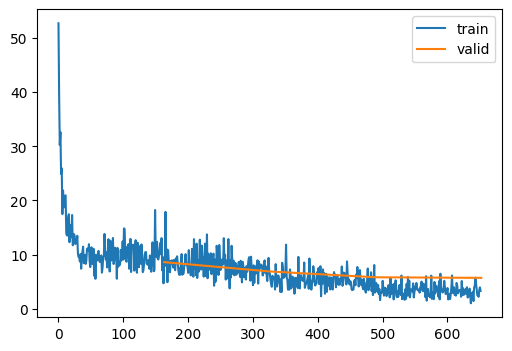

TimeR2Score,loss,epoch,train,time
0.719,12.479,0,True,00:02
0.830,7.467,0,False,00:00
0.843,6.970,1,True,00:02
0.833,7.318,1,False,00:00
0.889,4.925,2,True,00:03
0.852,6.512,2,False,00:00
0.928,3.214,3,True,00:02
0.860,6.144,3,False,00:00


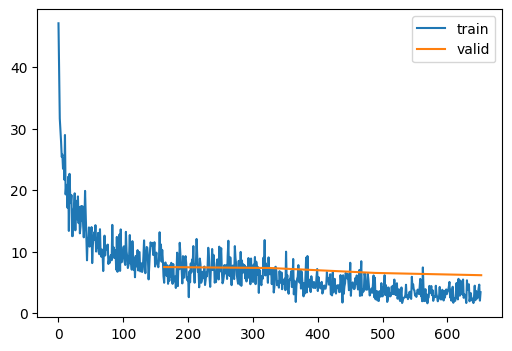

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.868,6.171,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.774,10.531,0,False,00:00


Inference on nascent
		preds, targs
tensor([[10.8495,  0.0000],
        [ 3.4633,  4.0000],
        [ 7.7479,  8.0000],
        [ 7.9626, 12.0000],
        [12.7734, 16.0000],
        [21.0783, 20.0000],
        [ 1.2386,  0.0000],
        [ 0.1991,  4.0000],
        [11.0793,  8.0000],
        [10.3088, 12.0000],
        [11.6457, 16.0000],
        [21.0421, 20.0000]])
result:  tensor(0.6530)


TimeR2Score,loss,epoch,train,time
0.682,15.041,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.813,8.852,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 3.5905,  1.0000],
        [ 4.3884,  4.0000],
        [ 6.2603,  7.0000],
        [ 9.4109, 10.0000],
        [13.3971, 13.0000],
        [ 8.2834, 16.0000],
        [20.3510, 19.0000],
        [21.3130, 22.0000]])
result:  tensor(0.8155)


TimeR2Score,loss,epoch,train,time
0.744,11.939,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.547,21.140,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 7.3635,  2.0000],
        [ 6.0609,  6.0000],
        [ 9.3524, 10.0000],
        [14.0518, 14.0000],
        [23.4981, 18.0000],
        [21.0986, 22.0000],
        [ 2.2474,  2.0000],
        [ 6.7226,  6.0000],
        [10.4935, 10.0000],
        [10.5603, 14.0000],
        [13.4281, 18.0000],
        [ 7.1661, 22.0000]])
result:  tensor(0.6825)


In [58]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.735,11.792,0,True,00:02
0.793,9.094,0,False,00:00
0.799,8.914,1,True,00:02
0.829,7.515,1,False,00:00
0.852,6.595,2,True,00:02
0.841,6.985,2,False,00:00
0.892,4.813,3,True,00:02
0.862,6.077,3,False,00:00
0.935,2.895,4,True,00:04
0.865,5.927,4,False,00:00


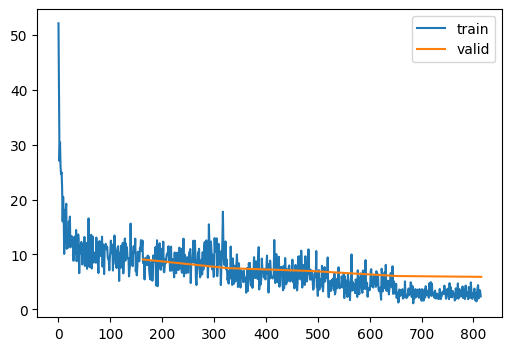

TimeR2Score,loss,epoch,train,time
0.708,12.960,0,True,00:03
0.783,9.516,0,False,00:00
0.779,9.834,1,True,00:03
0.780,9.655,1,False,00:00
0.781,9.714,2,True,00:03
0.815,8.140,2,False,00:00
0.821,7.942,3,True,00:03
0.818,8.001,3,False,00:00
0.853,6.519,4,True,00:02
0.826,7.636,4,False,00:00


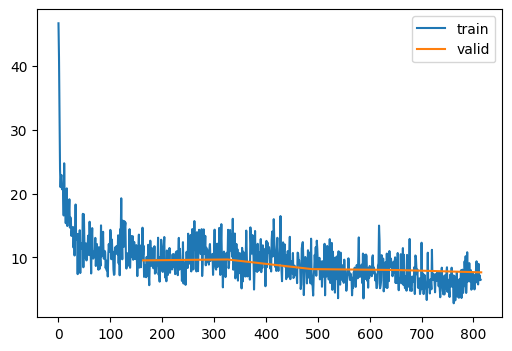

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.515,22.656,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.672,15.318,0,False,00:00


Inference on nascent
		preds, targs
tensor([[18.4597,  0.0000],
        [ 4.5365,  4.0000],
        [ 5.9045,  8.0000],
        [ 7.3011, 12.0000],
        [ 8.7369, 16.0000],
        [19.0773, 20.0000],
        [13.8736,  0.0000],
        [ 3.6878,  4.0000],
        [11.7874,  8.0000],
        [ 9.4583, 12.0000],
        [16.8773, 16.0000],
        [20.5320, 20.0000]])
result:  tensor(0.5794)


TimeR2Score,loss,epoch,train,time
0.837,7.724,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.703,14.052,0,False,00:00


Inference on gro
		preds, targs
tensor([[11.5655,  1.0000],
        [12.7235,  4.0000],
        [ 4.4083,  7.0000],
        [ 9.8052, 10.0000],
        [13.6251, 13.0000],
        [10.9240, 16.0000],
        [22.1856, 19.0000],
        [21.7994, 22.0000]])
result:  tensor(0.3893)


TimeR2Score,loss,epoch,train,time
0.388,28.567,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.886,5.326,0,False,00:00


Inference on rna
		preds, targs
tensor([[16.4292,  2.0000],
        [ 5.1429,  6.0000],
        [ 9.4930, 10.0000],
        [13.5913, 14.0000],
        [21.7662, 18.0000],
        [20.0627, 22.0000],
        [12.6998,  2.0000],
        [ 7.8745,  6.0000],
        [10.7571, 10.0000],
        [10.9921, 14.0000],
        [16.5697, 18.0000],
        [16.4703, 22.0000]])
result:  tensor(0.5162)


In [59]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.750,11.107,0,True,00:02
0.811,8.320,0,False,00:00
0.834,7.355,1,True,00:02
0.841,6.993,1,False,00:00
0.880,5.318,2,True,00:02
0.846,6.783,2,False,00:00
0.921,3.526,3,True,00:02
0.866,5.899,3,False,00:00
0.947,2.354,4,True,00:02
0.874,5.517,4,False,00:00


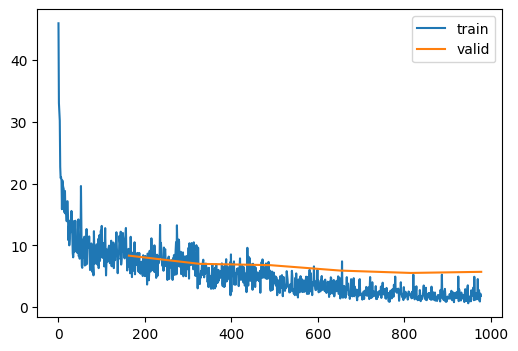

TimeR2Score,loss,epoch,train,time
0.702,13.241,0,True,00:02
0.798,8.889,0,False,00:00
0.792,9.237,1,True,00:02
0.828,7.538,1,False,00:00
0.837,7.243,2,True,00:02
0.860,6.134,2,False,00:00
0.887,5.040,3,True,00:02
0.878,5.374,3,False,00:00
0.915,3.780,4,True,00:02
0.885,5.060,4,False,00:00


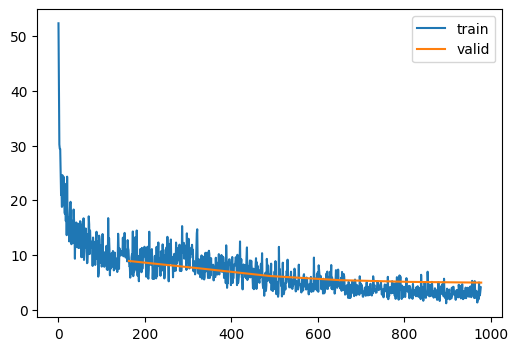

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.651,16.269,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.785,10.012,0,False,00:00


Inference on nascent
		preds, targs
tensor([[17.8732,  0.0000],
        [ 6.9983,  4.0000],
        [ 7.6726,  8.0000],
        [ 8.9865, 12.0000],
        [16.6811, 16.0000],
        [20.1641, 20.0000],
        [14.5337,  0.0000],
        [12.4469,  4.0000],
        [11.5848,  8.0000],
        [ 9.9918, 12.0000],
        [16.9185, 16.0000],
        [19.5163, 20.0000]])
result:  tensor(0.5801)


TimeR2Score,loss,epoch,train,time
0.911,4.223,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.908,4.356,0,False,00:00


Inference on gro
		preds, targs
tensor([[12.2498,  1.0000],
        [15.4584,  4.0000],
        [ 6.0431,  7.0000],
        [ 9.2159, 10.0000],
        [13.5447, 13.0000],
        [12.8240, 16.0000],
        [20.4012, 19.0000],
        [20.1535, 22.0000]])
result:  tensor(0.2721)


TimeR2Score,loss,epoch,train,time
0.540,21.487,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.886,5.327,0,False,00:00


Inference on rna
		preds, targs
tensor([[19.5797,  2.0000],
        [ 5.8337,  6.0000],
        [ 9.8734, 10.0000],
        [13.9143, 14.0000],
        [21.8833, 18.0000],
        [20.7262, 22.0000],
        [13.8486,  2.0000],
        [ 7.1074,  6.0000],
        [10.7875, 10.0000],
        [11.7882, 14.0000],
        [21.9581, 18.0000],
        [18.6854, 22.0000]])
result:  tensor(0.5862)


In [60]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.